In [41]:
# Import libraries to be used.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler

In [42]:
# Define a random state value
RANDOM_STATE = 3030

In [43]:
# Define column names which will be used instead of the ones in the datasets.
column_names = [
    "age", "sex", "chest_pain_type", "rest_bp", "cholesterol",
    "fasting_bs", "resting_ecg", "max_hr", "exercise_angina", "st_exercise_depression",
    "st_exercise_slope", "major_vessels_fluorospy", "thal", "angiographic_disease"
]
na_values = ["?"] # Define what values will be interpreted as missing values, in this dataset the "?" character is used for this.

# Load all datasets using relative paths and combine into one dataframe.
df = pd.concat([
    pd.read_csv("../data/processed.cleveland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.hungarian.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.switzerland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.va.data", names=column_names, na_values=na_values)
]).drop(['st_exercise_slope', 'major_vessels_fluorospy', 'thal'], axis=1)

In [44]:
df[df["angiographic_disease"] > 1] = 1

In [45]:
df['age'].fillna((df['age'].mean()), inplace=True)
df['rest_bp'].fillna((df['rest_bp'].mean()), inplace=True)
df['cholesterol'].fillna((df['cholesterol'].mean()), inplace=True)
df['max_hr'].fillna((df['max_hr'].mean()), inplace=True)
df['st_exercise_depression'].fillna((df['st_exercise_depression'].mean()), inplace=True)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [46]:
# Set category attributes
df["sex"] = df["sex"].astype("category")
df["chest_pain_type"] = df["chest_pain_type"].astype("category")
df["fasting_bs"] = df["fasting_bs"].astype("category")
df["resting_ecg"] = df["resting_ecg"].astype("category")
df["exercise_angina"] = df["exercise_angina"].astype("category")
df["angiographic_disease"] = df["angiographic_disease"].astype("category")

In [47]:
df_X = df.drop(["angiographic_disease"], axis=1)

In [48]:
X = MinMaxScaler().fit_transform(df_X.to_numpy())
Y = df["angiographic_disease"].to_numpy()

In [49]:
evaluation_results = {}
calculated_scores = []
SCORERS = ["roc_auc", "f1_macro", "accuracy", 'recall', 'precision', 'jaccard']
GS_PARAMETERS = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1, 5, 10]}
CV_K = 10

for i in range(0, 5):
    n_features = 2*(i+1)
    # Find the best k features
    select_k_best = SelectKBest(chi2, k=n_features).fit(X, Y)
    X_new = select_k_best.transform(X)

    # Perform grid search to find the best estimator for this feature set
    svm = SVC(random_state=RANDOM_STATE)
    clf = GridSearchCV(estimator=svm, param_grid=GS_PARAMETERS, refit=False)
    clf.fit(X_new, Y)
    best_estimator = SVC(**clf.best_params_, random_state=RANDOM_STATE)

    index_name = "{}_features".format(n_features)
    selected_features = select_k_best.get_feature_names_out(input_features=df_X.columns)
    evaluation_results[index_name] = {"scores": {}, "features": selected_features, "best_estimator": best_estimator}

    print("Running {}-CV with features={}, estimator={}".format(CV_K, selected_features, best_estimator))

    # Perform cross-validation in order to evaluate the best parameter found by grid-search on the feature set.
    scores = cross_validate(estimator=best_estimator, X=X_new, y=Y, cv=CV_K, scoring=SCORERS)
    # Retrieve names of scores for visualization purposes.
    for key in scores.keys():
        if ("test_" in key):
            score_name = key.split("test_")[1]
            if (score_name not in calculated_scores):
                calculated_scores.append(score_name)
            evaluation_results[index_name]["scores"][score_name] = scores[key]

Running 10-CV with features=['fasting_bs' 'exercise_angina'], estimator=SVC(C=1, kernel='linear', random_state=3030)
Running 10-CV with features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=SVC(C=1, kernel='linear', random_state=3030)
Running 10-CV with features=['age' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=SVC(C=1, kernel='linear', random_state=3030)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'max_hr' 'exercise_angina'], estimator=SVC(C=1, kernel='poly', random_state=3030)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'resting_ecg' 'max_hr' 'exercise_angina' 'st_exercise_depression'], estimator=SVC(C=10, kernel='linear', random_state=3030)


## Visualization

### Bar plots to show results from cross-validation

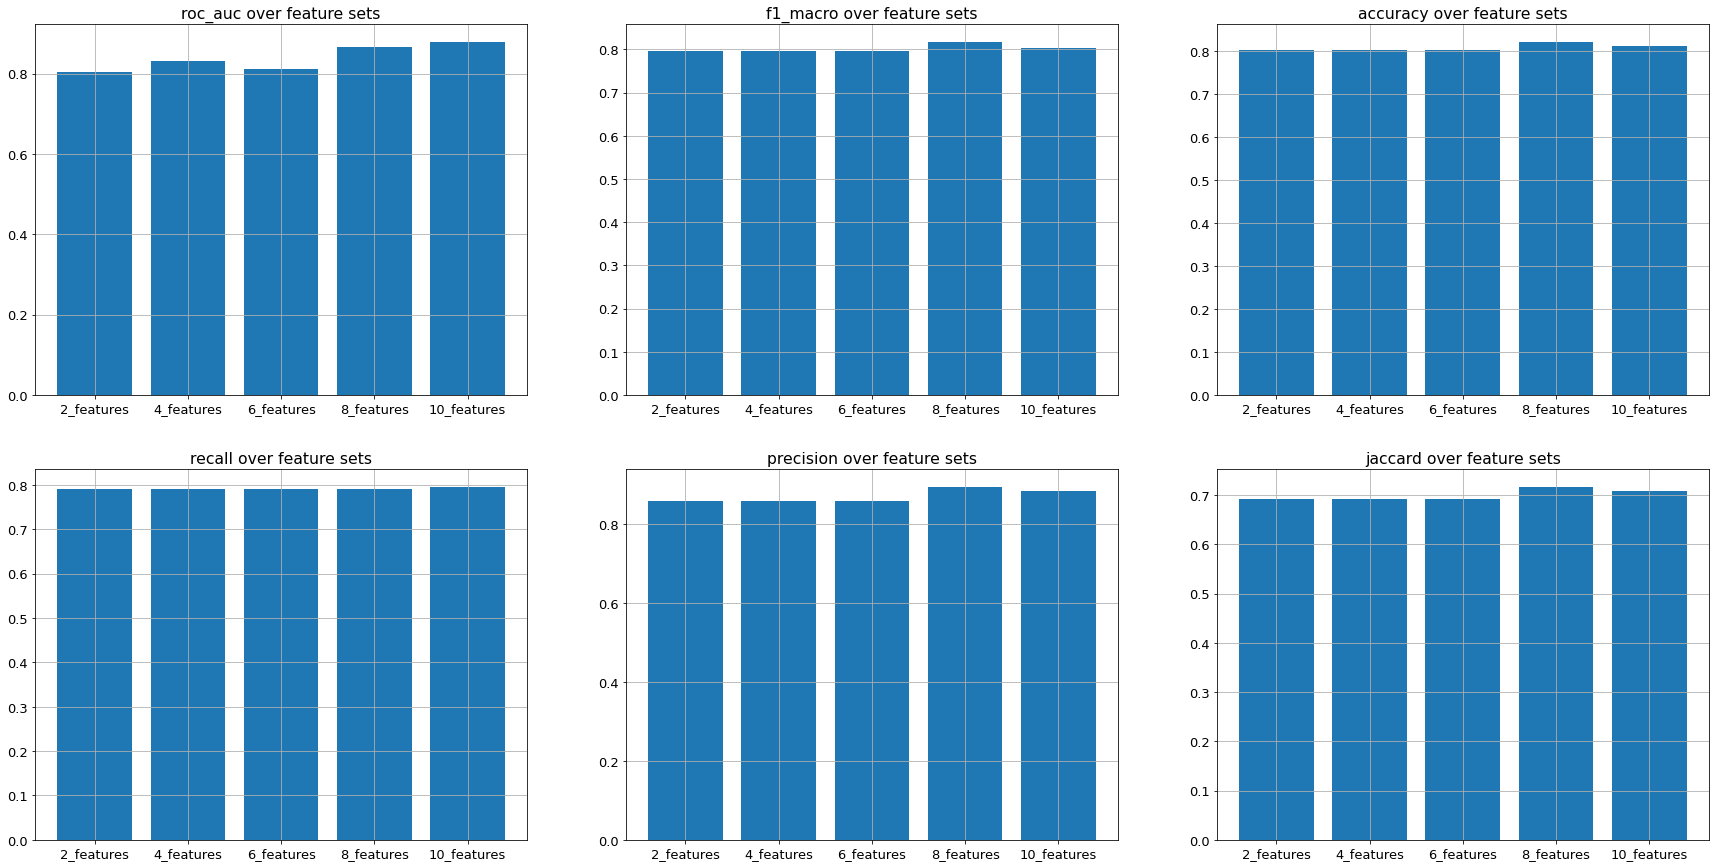

In [50]:
scores_to_plot = {}
# Plot settings.
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(30,15))

for i, score_name in enumerate(calculated_scores):
    scores_to_plot[score_name] = {}
    for feat_set in evaluation_results.keys():
        scores_to_plot[score_name][feat_set] = np.mean(evaluation_results[feat_set]["scores"][score_name])
    # Plot data.
    plt.subplot(2, 3, i+1)
    plt.bar(scores_to_plot[score_name].keys(), scores_to_plot[score_name].values())
    plt.title("{} over feature sets".format(score_name))
    plt.grid()

### Table to summarize cross-validation results as well as best estimator for each feature set

In [51]:
feature_set_keys = scores_to_plot[list(scores_to_plot.keys())[0]].keys()
rows = []
index_names = list(scores_to_plot.keys())
index_names.append("best_estimator")

# Gather scores by metric.
for score in scores_to_plot.keys():
    score_averages = []
    for feat_set in scores_to_plot[score].keys():
        score_averages.append(scores_to_plot[score][feat_set])
    rows.append(score_averages)

# Supplement rows with the best estimator by feature set.
best_estimators = []
for feat_set in evaluation_results.keys():
    best_estimators.append(evaluation_results[feat_set]["best_estimator"])
rows.append(best_estimators)

pd.DataFrame(data=rows, columns=evaluation_results.keys(), index=index_names)

,2_features,4_features,6_features,8_features,10_features
roc_auc,0.803622,0.830953,0.811452,0.866617,0.87838
f1_macro,0.79695,0.79695,0.79695,0.817237,0.803475
accuracy,0.802174,0.802174,0.802174,0.821739,0.811957
recall,0.789765,0.789765,0.789765,0.789765,0.795647
precision,0.858756,0.858756,0.858756,0.894772,0.883573
jaccard,0.692409,0.692409,0.692409,0.716667,0.708885
best_estimator,"SVC(C=1, kernel='linear', random_state=3030)","SVC(C=1, kernel='linear', random_state=3030)","SVC(C=1, kernel='linear', random_state=3030)","SVC(C=1, kernel='poly', random_state=3030)","SVC(C=10, kernel='linear', random_state=3030)"


## Conclusion

### Best feature set and estimator
All feature set/estimator combinations seem to produce very similar metrics, with the exception of the 8-, and 10-feature sets. In these two sets, the 8-feature set slightly outperforms the 10-feature set in all metrics except for in the `ROC_AUC` and `recall` metric, where the differences are also very small. Therefore, the 8-feature set with `C=1` and `kernel='poly'` can be considered to be the most suitable combination of feature set and estimator.